# Policy analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
savefig = True
savetab = True

In [3]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib.ticker import MaxNLocator, MultipleLocator
import json
import ptitprince as pt
import pickle as pkl
# import contextily as ctx
from unbreakable.analysis.analyzer import *
import ptitprince as pt
from ema_workbench import load_results
sns.set_theme(style="ticks")

## Load results

In [4]:
# Load results
income_loss = False
results = load_results(f'../experiments/scenarios=1000, policies=20.tar.gz')

# Prepare outcomes data frame
outcomes = prepare_outcomes(results, add_uncertainties=False, add_policies=True)

# This outcome should be studied separately
outcomes.drop('years_in_poverty', axis=1, inplace=True)

# Split my policy into two columns
outcomes[['target_group', 'top_up']] = outcomes['my_policy'].str.split('+', expand=True)

# Make top_up a categorical variable to ensure it is ordered correctly
outcomes['top_up'] = pd.Categorical(outcomes['top_up'], categories=['0', '10', '30', '50', '100'])
outcomes['target_group'] = pd.Categorical(outcomes['target_group'], categories=['poor', 'poor_near_poor1.25', 'poor_near_poor2.0', 'all'])

## What is the impact of top-ups across target groups and districts?

In [5]:
df = outcomes.copy()
columns_of_interest = [
       'target_group',
       'top_up', 
       'n_new_poor',
       'annual_average_consumption_loss_pct']
tab = df[columns_of_interest].round(2).groupby(['target_group', 'top_up']).mean(numeric_only=True).round(2)

In [6]:
top_up_mapper = {'0' : 'None', '10' : '10\%', '30': '30\%', '50': '50\%', '100': '100\%'}
# top_up_mapper = {'0' : 'None', '10' : '10%', '30': '30%', '50': '50%', '100': '100%'}
target_group_mapper = {'all' : 'All', 'poor' : 'Poor', 'poor_near_poor1.25' : 'Poor and Near Poor (1.25)', 'poor_near_poor2.0' : 'Poor and Near Poor (2.0)'}
# outcome_name_mapper = {'annual_average_consumption_loss_pct' : 'Annual average consumption loss (\%)', 'n_new_poor' : 'Number of new poor'}
outcome_name_mapper = {'annual_average_consumption_loss_pct' : 'Annual average consumption loss (%)', 'n_new_poor' : 'Number of new poor'}

tab.rename(index = top_up_mapper, inplace = True)
tab.rename(index = target_group_mapper, inplace = True)
tab.rename(columns = outcome_name_mapper, inplace = True)
tab.index.names = ['Target group', 'Top-up percentage']

tab['Number of new poor'] = tab['Number of new poor'].astype(int)

In [7]:
n_target_groups = 4
# n_target_groups = 1
k = 0
m_top_ups = 4
# m_top_ups = 2
for i in range(n_target_groups):
    x = tab.iloc[k, 0]
    y = tab.iloc[k, 1]
    tab.iloc[k, 0] = 0
    tab.iloc[k, 1] = 0
    for j in range(k + 1, k + m_top_ups + 1):
        tab.iloc[j, 0] = x - tab.iloc[j, 0]
        tab.iloc[j, 1] = y - tab.iloc[j, 1]
    k += m_top_ups + 1

tab.columns = ['Average number of people preventing from falling into poverty',
               # 'Average reduction in consumption loss (\%)'
               'Average reduction in consumption loss (p.p.)'
               ]
tab = tab + 0
tab

Average number of people preventing from falling into poverty  \
Target group              Top-up percentage                                                                  
Poor                      None                                                               0               
                          10\%                                                               0               
                          30\%                                                               0               
                          50\%                                                               0               
                          100\%                                                              0               
Poor and Near Poor (1.25) None                                                               0               
                          10\%                                                               5               
                          30\%                                                              27               
                          50\%                                                              33               
                          100\%                                                             52               
Poor and Near Poor (2.0)  None                                                               0               
                          10\%                                                               7               
                          30\%                                                              31               
                          50\%                                                              39               
                          100\%                                                             59               
All                       None                                                               0               
                          10\%                                                               7               
                          30\%                                                              31               
                          50\%                                                              40               
                          100\%                                                             59               

                                             Average reduction in consumption loss (p.p.)  
Target group              Top-up percentage                                                
Poor                      None                                                       0.00  
                          10\%                                                       0.20  
                          30\%                                                       0.61  
                          50\%                                                       1.02  
                          100\%                                                      2.02  
Poor and Near Poor (1.25) None                                                       0.00  
                          10\%                                                       0.30  
                          30\%                                                       0.91  
                          50\%                                                       1.52  
                          100\%                                                      3.02  
Poor and Near Poor (2.0)  None                                                       0.00  
                          10\%                                                       0.55  
                          30\%                                                       1.66  
                          50\%                                                       2.78  
                          100\%                                                      5.53  
All                       None                              

In [8]:
tab.style.background_gradient(cmap='Blues', subset='Average number of people preventing from falling into poverty')\
         .background_gradient(cmap='Greens', subset='Average reduction in consumption loss (p.p.)')\
         .format(decimal='.', thousands=',', precision=2)\
         .to_latex(buf='../reports/tables/policy_analysis_country.tex',
                   caption='Impact of cash transfers across different target groups on the country scale.',
                   position='H',
                   convert_css=True,
                   hrules=True,
                   label='tab:policy_analysis_country',
                   sparse_index=True,
                   sparse_columns=True,
                   column_format='p{4cm}p{4cm}p{3cm}p{3cm}p{3cm}',
                   multicol_align="|c|",
                   position_float="centering",
                  )

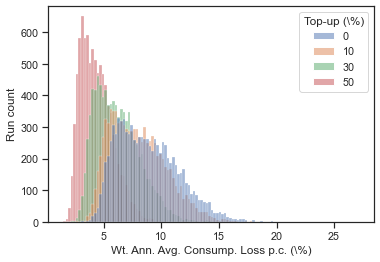

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))

if savefig:
    pct_symbol = '\%'
else:
    pct_symbol = '%'

target_group = 'all'
top_ups = ['0', '10', '30', '50'] # , '100']
df = outcomes[outcomes['target_group'] == target_group].copy()
df = df[df['top_up'].isin(top_ups)]
df['top_up'] = df['top_up'].astype(str)
df['top_up'] = pd.Categorical(df['top_up'], categories=top_ups, ordered=True)
df.rename(columns={'top_up': f'Top-up ({pct_symbol})'}, inplace=True)
outcome_of_interest = 'annual_average_consumption_loss_pct'
sns.histplot(data=df, x=outcome_of_interest, hue=f'Top-up ({pct_symbol})', ax=ax)
plt.xlabel(f'Wt. Ann. Avg. Consump. Loss p.c. ({pct_symbol})')
plt.ylabel('Run count')
if savefig:
    plt.savefig('../reports/figures/policy_analysis/top_up_all.pgf', bbox_inches='tight')
    plt.savefig('../reports/figures/policy_analysis/top_up_all.png', bbox_inches='tight', dpi=300);

else:
    plt.title('Top-up all affected households');

In [10]:
tab = df.copy()
outcome_of_interest = 'Wt. Ann. Avg. Consump. Loss p.c. (\%)'
tab.rename({'annual_average_consumption_loss_pct':
            'Wt. Ann. Avg. Consump. Loss p.c. (\%)'}, inplace=True, axis=1)
tab = tab.groupby('Top-up (\%)').describe()[[outcome_of_interest]]
tab.drop('count', axis=1, level=1, inplace=True)
tab = tab.rename({'25%': '25\%', '50%': '50\%', '75%': '75\%'}, axis=1, level=1)
tab = tab.T
style = tab.style.format(decimal='.', thousands=',', precision=2)
if savetab:
    style.to_latex(buf='../reports/tables/top_up_all_country.tex',
                caption='Impact of cash transfers to "All" target group on the country scale.',
                position='H',
                hrules=True,
                label='tab:top_up_all_country',
                sparse_index=True,
                sparse_columns=True,
                # column_format='p{4cm}p{4cm}p{3cm}p{3cm}p{3cm}'
                )
else:
    pass

## How the top-up to `all` mitigates the impact of a flood?

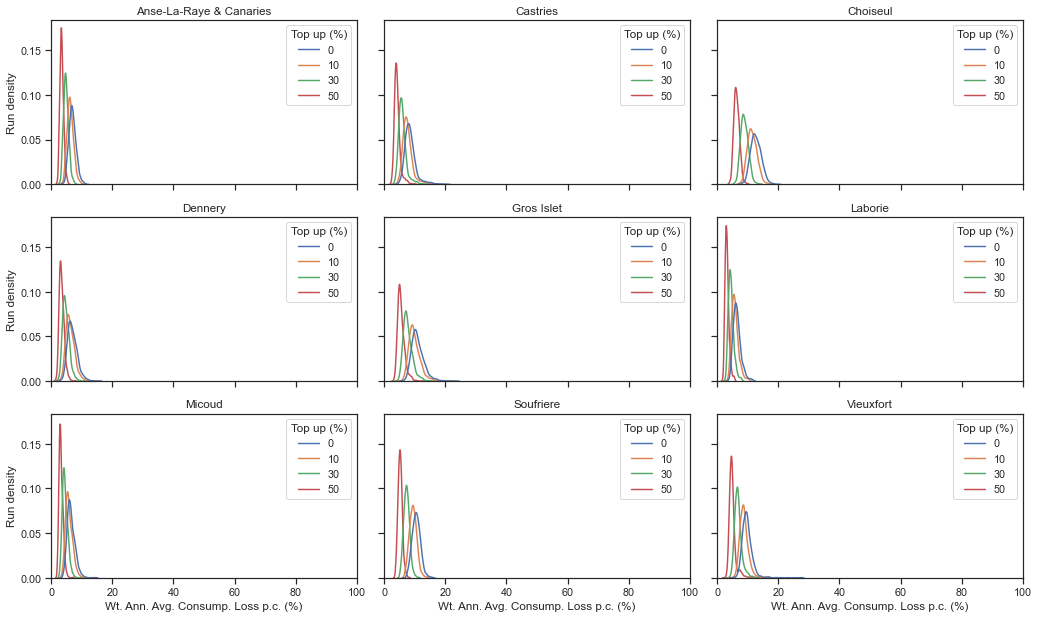

In [12]:
target_group = 'all'
top_ups = ['0', '10', '30', '50']
df = outcomes[outcomes['target_group'] == target_group]
df = df[df['top_up'].isin(top_ups)]
df['top_up'] = pd.Categorical(df['top_up'], categories=top_ups, ordered=True)

districts = df['district'].unique().tolist()
n_districts = len(districts)

fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5 * n_districts / 3, 3 * n_districts / 3), sharex=True, sharey=True)
colors = sns.color_palette('Set2', n_colors=len(districts))

# outcome_of_interest = 'n_new_poor'

outcome_name_mapper = {'annual_average_consumption_loss_pct': 'Wt. Ann. Avg. Consump. Loss p.c. (%)',
                       'n_new_poor': 'Number of new poor',
                       'n_new_poor_increase_pct' : 'Increase in number of new poor (%)'}

outcome_of_interest = 'annual_average_consumption_loss_pct'

for district in districts:
    data = df[df['district'] == district][['top_up', outcome_of_interest]]
    data.sort_values('top_up', inplace=True)
    data.rename(columns={'top_up': 'Top up (%)'}, inplace=True)
    if district == 'AnseLaRayeCanaries':
        district_name = 'Anse-La-Raye & Canaries'
    else:
        district_name = district
    i = districts.index(district) // 3
    j = districts.index(district) % 3
    color = colors[districts.index(district)]
    # sns.histplot(data=data, 
    #              x=outcome_of_interest, 
    #              hue='Top up', 
    #              ax=ax[i, j], 
    #              # multiple='stack', 
    #              # shrink=.8,
    #              # palette="ch:rot=-.25,hue=1,light=.75"
    #              )
    sns.kdeplot(data=data, 
                 x=outcome_of_interest, 
                 hue='Top up (%)', 
                 ax=ax[i, j], 
                 )
    ax[i, j].set_title(district_name)
    ax[i, j].set_ylabel('Run density')
    ax[i, j].set_xlabel(outcome_name_mapper[outcome_of_interest])
    ax[i, j].set_xlim(0, 100)
# fig.suptitle('Target group: ' + target_group_mapper[target_group], fontsize=16)
fig.tight_layout()
plt.savefig('../reports/figures/policy_analysis/top_up_all_country.png', dpi=300, bbox_inches='tight')

In [13]:
# Select target group
df = outcomes[outcomes['target_group'] == 'all']

# Select districts with low, mid and high consumption annual_average_consumption_loss_pct
districts_of_interest = ['Micoud', 'Laborie', 'Choiseul']
df = df[df['district'].isin(districts_of_interest)]

# Select top-ups of 0, 50 and 100
df = df[df['top_up'].isin(['0', '10', '30', '50'])]
df['top_up'] = df['top_up'].astype('str')
df['top_up'] = pd.Categorical(df['top_up'], ['0', '10', '30', '50'])
df.rename(columns={'top_up': 'Top-up (%)', 'district' : 'District', 'annual_average_consumption_loss_pct': 'Annual average consumption loss (%)'}, inplace=True)
df.sort_values(by='District', inplace=True)

## Which policies are the most effective?

### Consumption loss

In [15]:
df = get_policy_effectiveness_tab(outcomes)

In [16]:
# How effective is the policy in reducing income loss?
df.groupby(['Policy']).mean(numeric_only=True)['Annual average consumption loss (%)'].sort_values(ascending=True).round(2)

Policy
100% to all                          0.00
100% to poor and near poor (2.0)     3.30
50% to all                           4.40
100% to poor and near poor (1.25)    5.81
50% to poor and near poor (2.0)      6.05
30% to all                           6.19
100% to poor                         6.81
30% to poor and near poor (2.0)      7.17
50% to poor and near poor (1.25)     7.31
50% to poor                          7.81
30% to poor and near poor (1.25)     7.92
10% to all                           7.96
30% to poor                          8.22
10% to poor and near poor (2.0)      8.28
10% to poor and near poor (1.25)     8.53
10% to poor                          8.63
None                                 8.83
Name: Annual average consumption loss (%), dtype: float64

In [17]:
# What about the effectiveness by district?
df = df.groupby(['District', 'Policy']).mean(numeric_only=True)[['Annual average consumption loss (%)']] 
df = df.sort_values(by=['District', 'Annual average consumption loss (%)'])

In [18]:
top_3_policies = {}
for district in outcomes['district'].unique():
    top_3_policies[district] = df.loc[district, :].iloc[:3].index.tolist()
top_3_policies = pd.DataFrame(top_3_policies).T
top_3_policies.columns = [1, 2, 3]

bottom_3_policies = {}
for district in outcomes['district'].unique():
    bottom_3_policies[district] = df.loc[district, :].iloc[-4:-1].index.tolist()
bottom_3_policies = pd.DataFrame(bottom_3_policies).T
bottom_3_policies.columns = [1, 2, 3]

In [19]:
top_3_policies

,1,2,3
Anse-La-Raye & Canaries,100% to all,100% to poor and near poor (2.0),100% to poor and near poor (1.25)
Castries,100% to all,100% to poor and near poor (2.0),50% to all
Choiseul,100% to all,100% to poor and near poor (2.0),50% to all
Dennery,100% to all,100% to poor and near poor (2.0),50% to all
Gros Islet,100% to all,50% to all,100% to poor and near poor (2.0)
Laborie,100% to all,100% to poor and near poor (2.0),50% to all
Micoud,100% to all,100% to poor and near poor (2.0),50% to all
Soufriere,100% to all,100% to poor and near poor (2.0),50% to all
Vieuxfort,100% to all,100% to poor and near poor (2.0),50% to all


In [20]:
bottom_3_policies

,1,2,3
Anse-La-Raye & Canaries,10% to poor and near poor (2.0),10% to poor and near poor (1.25),10% to poor
Castries,10% to poor and near poor (2.0),10% to poor and near poor (1.25),10% to poor
Choiseul,30% to poor,10% to poor and near poor (1.25),10% to poor
Dennery,10% to poor and near poor (2.0),10% to poor and near poor (1.25),10% to poor
Gros Islet,30% to poor,10% to poor and near poor (1.25),10% to poor
Laborie,30% to poor,10% to poor and near poor (1.25),10% to poor
Micoud,10% to poor and near poor (2.0),10% to poor and near poor (1.25),10% to poor
Soufriere,30% to poor,10% to poor and near poor (1.25),10% to poor
Vieuxfort,10% to poor and near poor (2.0),10% to poor and near poor (1.25),10% to poor


### Number of poor

In [21]:
df = get_policy_effectiveness_tab(outcomes)

In [22]:
# How effective is the policy in reducing income loss?
df.groupby(['Policy']).mean(numeric_only=True)['Number of new poor'].sort_values(ascending=True).round(2)

Policy
100% to all                           0.00
100% to poor and near poor (2.0)      0.67
100% to poor and near poor (1.25)     7.69
50% to all                           19.45
50% to poor and near poor (2.0)      20.11
50% to poor and near poor (1.25)     26.92
30% to all                           28.05
30% to poor and near poor (2.0)      28.40
30% to poor and near poor (1.25)     32.97
10% to all                           52.26
10% to poor and near poor (2.0)      52.26
10% to poor and near poor (1.25)     54.13
None                                 59.39
30% to poor                          59.39
10% to poor                          59.39
50% to poor                          59.39
100% to poor                         59.39
Name: Number of new poor, dtype: float64

In [23]:
# How effective is the policy in reducing number of new poor
df = df.groupby(['District', 'Policy']).mean(numeric_only=True)[['Number of new poor']] 
df = df.sort_values(by=['District', 'Number of new poor'])

In [24]:
df

Number of new poor
District                Policy                                               
Anse-La-Raye & Canaries 100% to all                                     0.000
                        100% to poor and near poor (2.0)                0.000
                        100% to poor and near poor (1.25)               1.847
                        50% to all                                      4.364
                        50% to poor and near poor (2.0)                 4.364
...                                                                       ...
Vieuxfort               None                                          125.410
                        10% to poor                                   125.410
                        30% to poor                                   125.410
                        50% to poor                                   125.410
                        100% to poor                                  125.410

[153 rows x 1 columns]

In [25]:
top_3_policies = {}
for district in outcomes['district'].unique():
    top_3_policies[district] = df.loc[district, :].iloc[:3].index.tolist()
top_3_policies = pd.DataFrame(top_3_policies).T
top_3_policies.columns = [1, 2, 3]

bottom_3_policies = {}
for district in outcomes['district'].unique():
    bottom_3_policies[district] = df.loc[district, :].iloc[-4:-1].index.tolist()
bottom_3_policies = pd.DataFrame(bottom_3_policies).T
bottom_3_policies.columns = [1, 2, 3]

In [26]:
top_3_policies

,1,2,3
Anse-La-Raye & Canaries,100% to all,100% to poor and near poor (2.0),100% to poor and near poor (1.25)
Castries,100% to all,100% to poor and near poor (1.25),100% to poor and near poor (2.0)
Choiseul,100% to all,100% to poor and near poor (2.0),100% to poor and near poor (1.25)
Dennery,100% to all,100% to poor and near poor (2.0),100% to poor and near poor (1.25)
Gros Islet,100% to all,100% to poor and near poor (2.0),50% to all
Laborie,100% to all,100% to poor and near poor (1.25),100% to poor and near poor (2.0)
Micoud,50% to all,100% to all,50% to poor and near poor (2.0)
Soufriere,100% to all,100% to poor and near poor (2.0),100% to poor and near poor (1.25)
Vieuxfort,100% to all,50% to all,30% to all


In [27]:
bottom_3_policies

,1,2,3
Anse-La-Raye & Canaries,30% to poor,50% to poor,100% to poor
Castries,10% to poor,30% to poor,50% to poor
Choiseul,10% to poor,30% to poor,50% to poor
Dennery,100% to poor,10% to poor and near poor (1.25),30% to poor and near poor (1.25)
Gros Islet,10% to poor,30% to poor,50% to poor
Laborie,50% to poor,100% to poor,10% to poor and near poor (1.25)
Micoud,10% to poor,30% to poor,50% to poor
Soufriere,10% to poor,30% to poor,50% to poor
Vieuxfort,10% to poor,30% to poor,50% to poor
